# Projek Dicoding
## Belajar Pengembangan Machine Learning
### Natural Language Processing


---
##### Nama: Rangga Wibisana Putra Pamungkas
---
Projek Dicoding dari Belajar Pengembangan Machine Learning ini adalah membuat sebuah model yang akan mengidentifikasi sentiment dari sebuah tweet menggunakan Natural Language Processing Long Short-Term Memory (LSTM) Layer.

# 1. Loading the Dataset

In [1]:
# Menghubungkan Drive dengan Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Load dataset sebagai dataframe
import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/dataset.csv')

# Melihat sampel teratas dataframe
df.head()

,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
1,#BadBunny: Como dos gotas de agua: Joven se di...,es,negative
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious


In [3]:
df = df[df['Language']=='en']
df.head()

,Text,Language,Label
0,@Charlie_Corley @Kristine1G @amyklobuchar @Sty...,en,litigious
2,https://t.co/YJNiO0p1JV Flagstar Bank disclose...,en,litigious
3,Rwanda is set to host the headquarters of Unit...,en,positive
4,OOPS. I typed her name incorrectly (today’s br...,en,litigious
5,It sucks for me since I'm focused on the natur...,en,negative


In [4]:
random_samples = {}
labels = ['positive', 'negative', 'uncertainty', 'litigious']

for label in labels:
    label_data = df[df['Label'] == label]
    random_sample = label_data.sample(n=1500, random_state=42)
    random_samples[label] = random_sample

df_sample = pd.concat(random_samples.values(), ignore_index=True)
df_sample = df_sample.sample(frac=1, random_state=42)
df_sample = df_sample.reset_index(drop=True)
df_sample.head()

,Text,Language,Label
0,"@Raika55707128 @DrEricDing “Their” mind off, a...",en,negative
1,@PresidentFrick Unsure what time I'll even be ...,en,uncertainty
2,@NintendoUK OH! Id also like to say that reall...,en,positive
3,@Mydrworlds @DarelleBlack Oh but you wasn't ev...,en,negative
4,@Lloydisabigboi @WeRTottenhamTV I think he sti...,en,litigious


In [5]:
df_sample.info()
df_sample.isnull().values.any()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Text      6000 non-null   object
 1   Language  6000 non-null   object
 2   Label     6000 non-null   object
dtypes: object(3)
memory usage: 140.8+ KB


False

# Data Preprocessing

In [6]:
# Mengimpor paket yang diperlukan untuk memanipulasi teks dan membuat model.
import re, string, keras, nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import classification_report, accuracy_score, multilabel_confusion_matrix

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.callbacks import ReduceLROnPlateau, Callback

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [7]:
stop_words = set(stopwords.words('english')) | set(string.punctuation)
stop_words.update({'Ã', '±', 'ã', '¼', 'â', '»', '§'})

def clean_text(string):
  result = string.replace('\r\n', ' ').lower()  # Convert to lowercase and remove newlines
  result = re.sub(r'<[^>]+>\s*', ' ', result)  # Remove HTML tags
  result = re.sub(r"(?:\@|https?\://)\S+", "", result)  # Remove URLs
  # Remove non-ASCII characters
  result = re.sub(r'[^\x00-\x7f]', '', result)
  result = re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', result)
  result = " ".join(word.strip() for word in result)
  result = " ".join(word.strip() for word in re.split('#|_', result))
  result = re.sub('[^a-zA-Z\s]', ' ', result)  # Remove non-letters and non-spaces
  result = re.sub(r'\s+[a-zA-Z]\s+', ' ', result)
  result = re.sub(r'\s+', ' ', result)  # Collapse consecutive spaces
  result = ' '.join(word for word in result.split() if word not in stop_words)  # Remove stop words
  return result

# Apply cleaning and stop word removal to the 'review' column
df_sample['Text'] = df_sample['Text'].apply(lambda x: clean_text(x))
df_sample.head()

,Text,Language,Label
0,mind party fighting cult ones poor recall amon...,en,negative
1,unsure time even home going moms bit help move...,en,uncertainty
2,oh id also like say really biggest thing consi...,en,positive
3,oh even question always included,en,negative
4,think stil got years left contract,en,litigious


# Encoding Labels and Making Train-Test Splits

In [8]:
category = pd.get_dummies(df_sample.Label)
df_baru = pd.concat([df_sample.Text , category], axis=1)
df_baru.head()

,Text,litigious,negative,positive,uncertainty
0,mind party fighting cult ones poor recall amon...,0,1,0,0
1,unsure time even home going moms bit help move...,0,0,0,1
2,oh id also like say really biggest thing consi...,0,0,1,0
3,oh even question always included,0,1,0,0
4,think stil got years left contract,1,0,0,0


In [9]:
text = df_baru['Text'].values
labels = df_baru[['litigious', 'negative', 'positive', 'uncertainty']].values

In [10]:
# Membagi kumpulan data menjadi train dan test menggunakan train_test_split dengan 20% untuk test.
text_train, text_test, labels_train, labels_test = train_test_split(
    text, labels,
    test_size = 0.2,
    random_state=42,
    shuffle=True,
    stratify=labels
    )

In [11]:
def get_max_length():
    review_length = []
    for review in text_train:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))

In [12]:
# Melakukan tokenisasi dan mengkonversi sampel menjadi sequence
tokenizer = Tokenizer(num_words=5000, lower=False, oov_token='')
tokenizer.fit_on_texts(text_train)
tokenizer.fit_on_texts(text_test)

max_length = get_max_length()

# convert train dataset to sequence and pad sequences
train_sequences = tokenizer.texts_to_sequences(text_train)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length, truncating='post')

# convert Test dataset to sequence and pad sequences
test_sequences = tokenizer.texts_to_sequences(text_test)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length, truncating='post')

In [13]:
vocab_size = len(tokenizer.word_index) + 1 #index start from 0
print(vocab_size)
print(max_length)

15906
90


# Building the Model

In [14]:
# model initialization
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, 300, input_length=max_length),
    keras.layers.Bidirectional(keras.layers.LSTM(64)),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(4, activation='softmax')
])

# compile model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 90, 300)           4771800   
                                                                 
 bidirectional (Bidirection  (None, 128)               186880    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 batch_normalization (Batch  (None, 64)                256       
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

In [15]:
# Callback untuk mengurangi learning rate jika tidak ada peningkatan pada akurasi
reduce_lr = ReduceLROnPlateau(
    monitor="accuracy",
    patience=2,
    verbose=1,
    factor=0.5,
    min_lr=0.00001,
)


# Custom callback untuk menghentikan pelatihan jika akurasi mencapai lebih dari 90%
class MyEarlyStop(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (logs.get('accuracy') >= 0.9 and logs.get('val_accuracy')>=0.9):
            print(
                '\nFor Epoch',
                epoch+1,
                '\nAccuracy has reached = %2.2f%%' % (logs['accuracy'] * 100),
                ', Val Accuracy = %2.2f%%' % (logs['val_accuracy'] * 100),
                ', training has been stopped.'
            )
            self.model.stop_training = True

# Model Training and Evaluation

In [16]:
# Melakukan pelatihan pada model
history = model.fit(train_padded, labels_train,
                    epochs=30, verbose=1, batch_size = 128,
                    validation_data=(test_padded, labels_test),
                    callbacks=[reduce_lr, MyEarlyStop()])

Epoch 1/30
38/38 [==============================] - 34s 741ms/step - loss: 1.8835 - accuracy: 0.2723 - val_loss: 1.3790 - val_accuracy: 0.2542 - lr: 0.0010
Epoch 2/30
38/38 [==============================] - 22s 579ms/step - loss: 1.2305 - accuracy: 0.4915 - val_loss: 1.3011 - val_accuracy: 0.4850 - lr: 0.0010
Epoch 3/30
38/38 [==============================] - 22s 586ms/step - loss: 0.5182 - accuracy: 0.8252 - val_loss: 1.0921 - val_accuracy: 0.8700 - lr: 0.0010
Epoch 4/30
38/38 [==============================] - 23s 585ms/step - loss: 0.2685 - accuracy: 0.9375 - val_loss: 0.8957 - val_accuracy: 0.8850 - lr: 0.0010
Epoch 5/30
38/38 [==============================] - 21s 551ms/step - loss: 0.1565 - accuracy: 0.9744 - val_loss: 0.7259 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 6/30
38/38 [==============================] - ETA: 0s - loss: 0.1005 - accuracy: 0.9881
For Epoch 6 
Accuracy has reached = 98.81% , Val Accuracy = 90.33% , training has been stopped.
38/38 [=======================

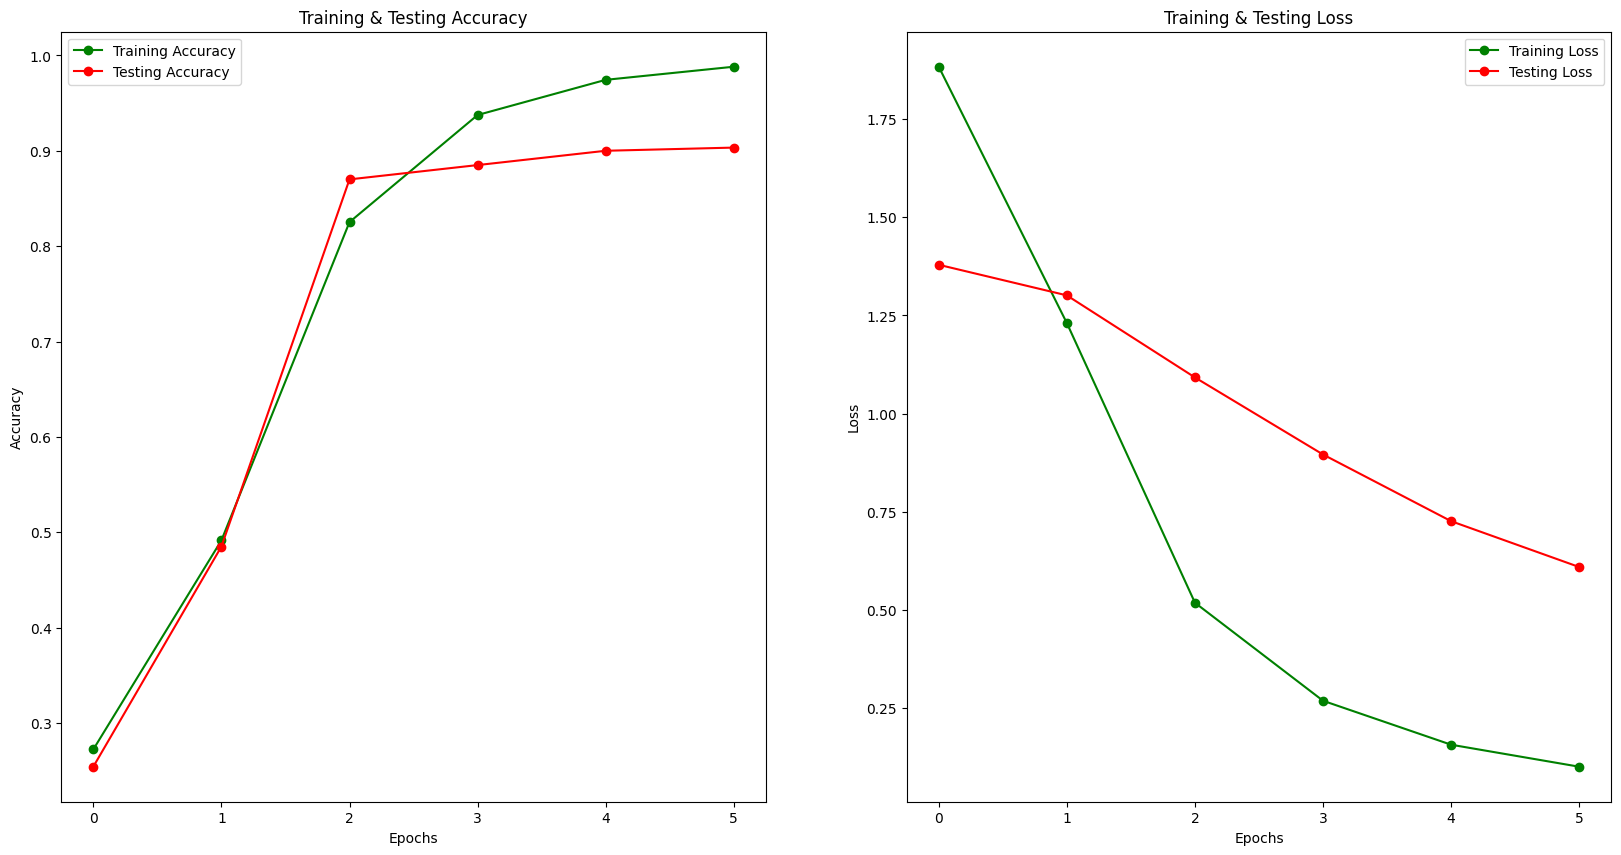

In [17]:
# Menampilkan plot accuracy dan loss
fig, ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

# Plot accuracy dan loss dari training
ax[0].plot(train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(val_acc , 'ro-' , label = 'Testing Accuracy')
ax[0].set_title('Training & Testing Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

# Plot accuracy dan loss dari testing
ax[1].plot(train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(val_loss , 'ro-' , label = 'Testing Loss')
ax[1].set_title('Training & Testing Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [18]:
# Melakukan prediksi pada data testing
pred = model.predict(test_padded)
pred[:5]

38/38 [==============================] - 3s 54ms/step


array([[0.12221972, 0.10023063, 0.6076906 , 0.1698591 ],
       [0.0992339 , 0.10053498, 0.1263553 , 0.67387587],
       [0.1533763 , 0.39698732, 0.31594604, 0.13369028],
       [0.6296672 , 0.11648889, 0.13659124, 0.11725265],
       [0.12778834, 0.613069  , 0.09209505, 0.1670477 ]], dtype=float32)

In [19]:
# Ubah prediksi menjadi 1
pred_mod = np.zeros_like(pred)
for i in range(len(pred)):
    pred_mod[i] = np.zeros(len(pred[i]))
    pred_mod[i][np.argmax(pred[i])] = 1

# Print hasil
print(pred_mod)

[[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 1. 0.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]


In [20]:
# Menampilkan Classification Report dari model
print(classification_report(labels_test, pred_mod, target_names = ['litigious', 'negative', 'positive', 'uncertainty']))

              precision    recall  f1-score   support

   litigious       0.95      0.90      0.92       300
    negative       0.92      0.84      0.88       300
    positive       0.92      0.92      0.92       300
 uncertainty       0.84      0.96      0.89       300

   micro avg       0.90      0.90      0.90      1200
   macro avg       0.91      0.90      0.90      1200
weighted avg       0.91      0.90      0.90      1200
 samples avg       0.90      0.90      0.90      1200

